## Explore training data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
df = pd.read_csv('data/ohlcv.csv.gz', compression='gzip')
print(df.shape)

df = df.head(500)
df.head(5)

(111655, 7)


,timestamp,symbol,open,high,low,close,volume
0,2023-01-01 00:00:00,BTC/USDT,16541.7700,16545.7000,16508.3900,16529.6700,4364.8357
1,2023-01-01 00:00:00,SOL/USDT,9.9700,10.0200,9.9300,9.9900,126479.6700
2,2023-01-01 00:00:00,ETH/USDT,1196.1300,1196.7000,1192.7200,1194.0900,5889.3840
3,2023-01-01 00:00:00,DOGE/USDT,0.0702,0.0703,0.0694,0.0698,40611931.0000
4,2023-01-01 00:00:00,XRP/USDT,0.3389,0.3390,0.3377,0.3385,11231966.0000


In [3]:
from trading_utils import preprocess_data, create_wide_format_data, SYMBOLS
TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']

symbols = ['BTC'] #SYMBOLS
all_data = preprocess_data(df)
observations_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=symbols, 
    features=TECHNICAL_FEATURES
)

observations_df.shape, prices_df.shape

((81, 8), (81, 1))

In [4]:
# observation data
observations_df.head(5)

,BTC_price_change,BTC_volume_change,BTC_rsi,BTC_macd,BTC_macd_signal,BTC_macd_hist,BTC_bb_percent_b,BTC_bb_bandwidth
timestamp,,,,,,,,
2023-01-01 19:00:00,0.0007,0.1359,54.6666,14.0088,7.8494,6.1595,1.0870,0.0055
2023-01-01 20:00:00,0.0001,-0.1106,54.9600,16.0869,9.4969,6.5900,1.0047,0.0062
2023-01-01 21:00:00,0.0001,-0.1271,55.6444,17.7048,11.1385,6.5663,0.9516,0.0068
2023-01-01 22:00:00,-0.0003,0.0091,53.6614,18.4069,12.5921,5.8147,0.8644,0.0072
2023-01-01 23:00:00,0.0009,0.0424,58.3463,19.9142,14.0566,5.8576,0.9230,0.0077


In [5]:
# prices data
prices_df.head(5)

symbol,BTC
timestamp,
2023-01-01 19:00:00,16603.0800
2023-01-01 20:00:00,16604.5100
2023-01-01 21:00:00,16606.6800
2023-01-01 22:00:00,16602.1200
2023-01-01 23:00:00,16616.7500


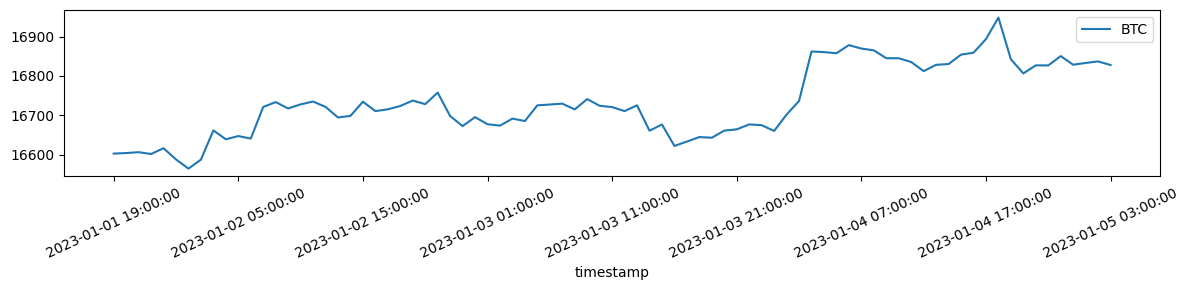

In [6]:
fig, a = plt.subplots(len(symbols), 1, figsize=(12, len(symbols) * 3), tight_layout=True)
prices_df.plot(ax=a, subplots=True, rot=25);

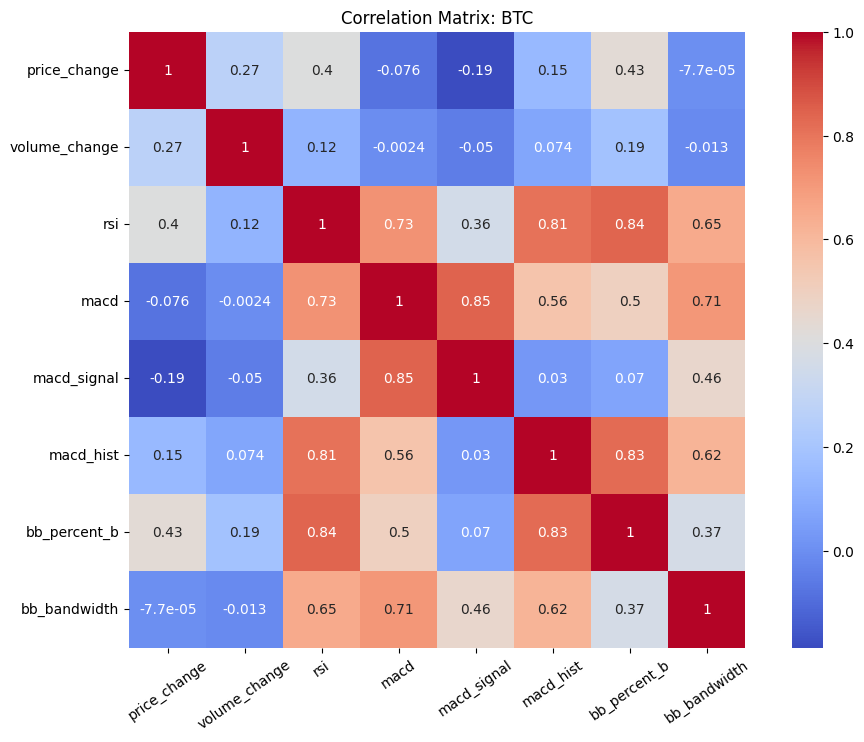

In [7]:
for symbol in symbols:
    columns = [f"{symbol}_{feature}" for feature in TECHNICAL_FEATURES]
    features_df = observations_df[columns].rename(columns=dict(zip(columns, TECHNICAL_FEATURES)))

    corr = features_df.corr()
    plt.figure(figsize=(12, 8))
    plt.title(f"Correlation Matrix: {symbol}")
    hm = sns.heatmap(corr, vmax=1, square=True, annot=True, cmap="coolwarm")
    hm.set_xticklabels(hm.get_xticklabels(), rotation = 35)
    plt.show()

In [8]:
%pip install plotly
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

init_notebook_mode(connected=True)         # initiate notebook for offline plot

Note: you may need to restart the kernel to use updated packages.


In [10]:
macd_columns = ['macd', 'macd_signal', 'macd_hist']

columns = [f"BTC_{feature}" for feature in macd_columns]
features_df = observations_df[columns].rename(columns=dict(zip(columns, macd_columns)))

fig = make_subplots(rows=2, cols=1)

# price Line
fig.append_trace(
    go.Scatter(
        x=prices_df.index,
        y=prices_df['BTC'],
        line=dict(color='rgb(0,100,200)', width=1),
        name='BTC',
        # showlegend=False,
        legendgroup='1',
    ), row=1, col=1
)

fig.append_trace(
    go.Scatter(
        x=features_df.index,
        y=features_df['macd'],
        line=dict(color='rgb(0,0,0)', width=1),
        name='macd',
        # showlegend=False,
        legendgroup='2',
    ), row=2, col=1
)


# Slow signal (%d)
fig.append_trace(
    go.Scatter(
        x=features_df.index,
        y=features_df['macd_signal'],
        line=dict(color='rgb(0,181,226)', width=1),
        # showlegend=False,
        legendgroup='2',
        name='macd_signal'
    ), row=2, col=1
)


# Colorize the histogram values
colors = np.where(features_df['macd_hist'] > 0, 'rgb(0,177,64)', 'rgb(255,0,0)')


# Plot the histogram
fig.append_trace(
    go.Bar(
        x=features_df.index,
        y=features_df['macd_hist'],
        name='macd_hist',
        marker_color=colors,
    ), row=2, col=1
)


# Make it pretty
layout = go.Layout(
    plot_bgcolor='rgb(255,255,255)',
    # Font Families
    font_family='Arial',
    font_color='rgb(82,82,82)',
    font_size=12,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)


# Update options and show plot
fig.update_layout(layout)


fig.show()

#iplot(fig)


# plt.figure(figsize=(12, 8))
# plt.title(f"MACD: {symbol}")
# plt.plot(features_df)
# plt.show()

# corr = features_df.corr()
# plt.figure(figsize=(12, 8))
# plt.title(f"Correlation Matrix: {symbol}")
# hm = sns.heatmap(corr, vmax=1, square=True, annot=True, cmap="coolwarm")
# hm.set_xticklabels(hm.get_xticklabels(), rotation = 35)
# plt.show()